# Notebook Examples for Capter 5 Part 2

In [1]:
import warnings
# these are innocuous but irritating
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
%matplotlib inline

### Pauli representation

__Note__: The RADARSAT-2 image used here is not available in the imagery folder.

In [ ]:
run scripts/dispms -f myimagery/RS2_20090829.tif -p [6,9,1] \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_16.eps'

### Determining the equivalent number of looks (ENL)

In [ ]:
run scripts/enlml -d [500,400,300,300] myimagery/RS2_20090829.tif

In [ ]:
run scripts/dispms -f myimagery/RS2_20090829_enl.tif -e 2 \
-F myimagery/RS2_20090829.tif -D [500,400,300,300] \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_18.eps'

### Minimum mean square error (mmse) filter

In [ ]:
run scripts/mmse_filter myimagery/RS2_20090829.tif 12.5

In [ ]:
run scripts/dispms -f myimagery/RS2_20090829_mmse.tif -p [6,9,1] -d [200,200,400,400] \
-F myimagery/RS2_20090829.tif -P [6,9,1] -D [200,200,400,400] \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_19.eps'

### Gamma-MAP filter

In [ ]:
run scripts/gamma_filter myimagery/RS2_20090829.tif 12.5

In [ ]:
run scripts/dispms -f myimagery/RS2_20090829_mmse.tif -p [6,9,1] -d [200,200,400,400] \
-F myimagery/RS2_20090829_gamma.tif -P [2,3,1] -D [200,200,400,400] \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_20.eps'

### Temporal filtering

In [ ]:
import ee, math
ee.Initialize()

# convert from decibels to linear scale
def linearize(current):
    return current.multiply(
      ee.Image.constant(math.log(10.0)/10.0)).exp()

# collect a time series
rect = ee.Geometry.Rectangle([6.31,50.83,6.58,50.95]);
collection = ee.ImageCollection('COPERNICUS/S1_GRD')\
.filterBounds(rect)\
.filterDate(ee.Date('2017-05-01'),ee.Date('2017-06-01'))\
.filter(ee.Filter.eq('resolution_meters', 10)) \
.filter(ee.Filter.eq('orbitProperties_pass','ASCENDING'))\
.map(linearize)  

# series length
count =  collection.toList(100).length()            
print 'series length: %i'%count.getInfo()  

# temporally filtered image band
filtered = collection.mean().select(0).clip(rect)

# unfiltered image band for comparison
unfiltered = ee.Image(collection.first()).select(0)\
                                        .clip(rect)
    
# export to Google Drive
outimage = ee.Image.cat(unfiltered,filtered)
gdexport = ee.batch.Export.image.toDrive(outimage,
     description='driveExportTask', 
     folder = 'EarthEngineImages',
     fileNamePrefix='temporalfiltered',scale=10)                
gdexport.start() 

In [ ]:
run scripts/dispms -f imagery/temporalfiltered.tif \
                     -d [800,400,600,600] -p [1,1,1]\
                   -F imagery/temporalfiltered.tif \
                     -D [800,400,600,600] -P [2,2,2] \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_21.eps'            

### Slope and aspect

In [ ]:
!gdaldem slope imagery/AST_DEM imagery/ASTslope.tif

In [ ]:
!gdaldem aspect imagery/AST_DEM imagery/ASTaspect.tif

In [ ]:
run scripts/dispms -f imagery/ASTslope.tif \
  -F imagery/ASTaspect.tif \
#-s  '/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_30.eps'   

### Illumination correction

In [ ]:
run scripts/dispms -f imagery/AST_DEM -e 2

#### Download LS5 image and DEM

In [ ]:
import IPython.display as disp

rect = ee.Geometry.Rectangle([-124.705,48.414,-123.799,49.026])
image = ee.Image('LANDSAT/LT05/C01/T1/LT05_048026_19840717') \
          .select('B1','B2','B3','B4','B5','B7') \
          .clip(rect)     
crs = image.projection().crs().getInfo()
    
dem = ee.Image('USGS/SRTMGL1_003').clip(rect)

# export to Google Drive
gdexport = ee.batch.Export.image.toDrive(image,
     description='driveExportTask', 
     folder = 'EarthEngineImages',
     fileNamePrefix='LS19840717',scale=30)                
gdexport.start() 

gdexport = ee.batch.Export.image.toDrive(dem,
     description='driveExportTask', 
     folder = 'EarthEngineImages',
     crs = crs, 
     fileNamePrefix='SRTM',scale=30)                
gdexport.start() 

In [ ]:
run scripts/dispms -f myimagery/LS19840717.tif -e 3 -p [4,5,6] -d [100,500,1600,1600] \
-F myimagery/SRTM.tif -E 3 -D [100,500,1600,1600] \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_32.eps'

In [ ]:
run scripts/pca -d [100,500,1600,1600] myimagery/LS19840717.tif

In [ ]:
run scripts/dispms -f myimagery/LS19840717_pca.tif -e 3 -p [1,2,3]

In [ ]:
run scripts/em -p [1,2,3] -K 3 myimagery/LS19840717_pca.tif

In [ ]:
%run scripts/dispms -f  myimagery/LS19840717_pca_em.tif -c  \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_33.eps'

In [ ]:
run scripts/c_corr -d [100,500,1600,1600] \
  -c myimagery/LS19840717_pca_em.tif \
  132.9 54.9 myimagery/LS19840717.tif myimagery/SRTM.tif

In [ ]:
run scripts/dispms -f myimagery/LS19840717.tif -d [100,500,1000,1000] -p [4,4,4]  \
-F myimagery/LS19840717_corr.tif -P [4,4,4] -D [0,0,1000,1000]  \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_35.eps'

In [ ]:
run scripts/dispms -f myimagery/cosgamma -e 4 \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_34.eps'

### Frequency domain  registration

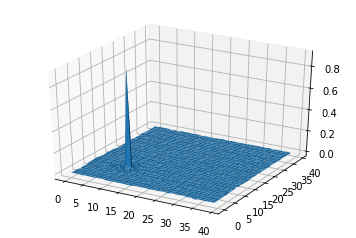

In [8]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# grab an image band
gdal.AllRegister()
inDataset = gdal.Open('imagery/AST_20070501')
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize  
band = inDataset.GetRasterBand(3) \
             .ReadAsArray(0,0,cols,rows)  

# calculate and invert cross-power spectrum
g1 = band[10:522,10:522]
g2 = band[0:512,0:512]
f1 = fft.fft2(g1)
f2 = fft.fft2(g2)
g = fft.ifft2(f2*np.conj(f1)/np.absolute(f1)**2)

# plot
fig = plt.figure()
ax = fig.gca(projection='3d') 
x, y = np.meshgrid(range(40),range(40))
ax.plot_surface(x, y, np.real(g[0:40,0:40]))

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_36.eps',bbox_inches='tight')

### Re-sampling with ground control points

In [2]:
run scripts/ex5_3 imagery/gcps.pts

RST transformation:
[[ 9.99972110e-01 -2.02991329e-03  2.10315125e+02]
 [ 2.02991329e-03  9.99972110e-01 -1.84336787e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
RMS: 0.504769
